### K-means clustering

In [1]:

import pandas as pd
import numpy as np

# Load data
seg_df = pd.read_csv('retentiondata_case.csv')
seg_df.head()

,acct_ref,cust_ref,has_dependents,tenure_mo,home_phone,multi_line,internet_plan,add_on_security,add_on_backup,add_on_protection,...,recent_offer,avg_long_dist_fee,internet_tech,avg_gb_download,premium_support,stream_music,unlimited_data_opt,refunds_total,extra_data_fees_total,long_dist_fees_total
0,ACCT137932,CUST61880322,No,1,No,No phone service,DSL,No,Yes,No,...,Offer E,0.00,DSL,10,No,No,Yes,0.0,0,0.00
1,ACCT115088,CUST55192304,No,34,Yes,No,DSL,Yes,No,Yes,...,NaN,17.09,DSL,16,No,No,Yes,0.0,0,581.06
2,ACCT623423,CUST16890051,No,2,Yes,No,DSL,Yes,Yes,No,...,NaN,10.47,DSL,21,No,No,Yes,0.0,0,20.94
3,ACCT846960,CUST99388728,No,45,No,No phone service,DSL,Yes,No,Yes,...,NaN,0.00,DSL,10,Yes,No,Yes,0.0,0,0.00
4,ACCT146586,CUST91125265,No,2,Yes,No,Fiber optic,No,No,No,...,NaN,9.12,Fiber Optic,51,No,No,Yes,0.0,0,18.24


In [2]:
# Moving important features into different df for segmentation

cols_to_move = ["age_years","tenure_mo","contract_term","tech_support_std", "has_dependents"]

seg_df_num = seg_df[cols_to_move].copy()

In [3]:
# Contract term: 1 = Month to month, 0 = otherwise
seg_df_num['contract_term'] = np.where(
    seg_df_num['contract_term'].astype(str) == 'Month-to-month', 1, 0
)

# Internet plan: 1 = Fiber optic, 0 = otherwise
#seg_df_num['internet_plan'] = np.where(
#    seg_df_num['internet_plan'].astype(str) == 'Fiber optic', 1, 0
#)

# Add-on security: 1 = Yes, 0 = No
#seg_df_num['add_on_security'] = np.where(
#   seg_df_num['add_on_security'].astype(str) == 'Yes', 1, 0)

# Tech support standard: 1 = Yes, 0 = No
seg_df_num['tech_support_std'] = np.where(
    seg_df_num['tech_support_std'].astype(str) == 'Yes', 1, 0
)

#has_dependents: 1 = Yes, 0 = No
seg_df_num['has_dependents'] = np.where(
    seg_df_num['has_dependents'].astype(str) == 'Yes', 1, 0
)

# Summary
seg_df_num.describe(include='all')

,age_years,tenure_mo,contract_term,tech_support_std,has_dependents
count,5636.000000,5636.000000,5636.000000,5636.000000,5636.000000
mean,46.680092,32.445174,0.549503,0.293293,0.297906
std,16.754494,24.515986,0.497588,0.455312,0.457379
min,19.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,9.000000,0.000000,0.000000,0.000000
50%,46.000000,29.000000,1.000000,0.000000,0.000000
75%,60.000000,55.000000,1.000000,1.000000,1.000000
max,80.000000,72.000000,1.000000,1.000000,1.000000


In [4]:
print(seg_df_num)

      contract_term  tech_support_std  has_dependents
0                 1                 1               1
1                 0                 1               1
2                 1                 1               1
3                 0                 0               1
4                 1                 1               1
...             ...               ...             ...
5631              1                 1               1
5632              0                 0               1
5633              0                 0               1
5634              1                 1               1
5635              0                 0               1

[5636 rows x 3 columns]


In [4]:
# Running K-means
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, n_init=25, random_state=943)
labels = kmeans.fit_predict(seg_df_num)

# Add cluster labels back to the dataframe
seg_df_num['cluster'] = labels

kmeans.cluster_centers_

array([[61.3170418 , 14.0681672 ,  0.8244373 ,  0.18006431,  0.21221865],
       [33.44097996, 56.63177431,  0.19227914,  0.43504083,  0.41870824],
       [32.82316314, 12.09090909,  0.78953923,  0.19302615,  0.27334994],
       [62.04078014, 57.87588652,  0.25531915,  0.42287234,  0.30673759]])

In [5]:
#Inspect cluster means

centers = pd.DataFrame(kmeans.cluster_centers_, columns=seg_df_num.drop(columns=['cluster']).columns)
centers

,age_years,tenure_mo,contract_term,tech_support_std,has_dependents
0,61.317042,14.068167,0.824437,0.180064,0.212219
1,33.440980,56.631774,0.192279,0.435041,0.418708
2,32.823163,12.090909,0.789539,0.193026,0.273350
3,62.040780,57.875887,0.255319,0.422872,0.306738


<Figure size 640x480 with 0 Axes>

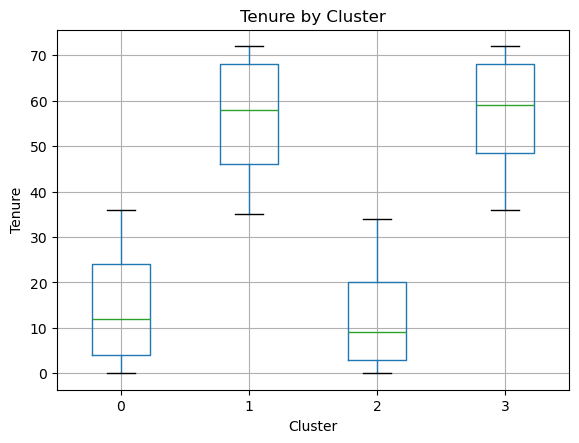

In [6]:
import matplotlib.pyplot as plt

# Ensure income exists
if 'tenure_mo' not in seg_df_num.columns:
    raise KeyError("Expected a 'tenure_mo' column in the dataset.")

plt.figure()
seg_df_num.boxplot(column='tenure_mo', by='cluster')
plt.title('Tenure by Cluster')
plt.suptitle('')
plt.xlabel('Cluster')
plt.ylabel('Tenure')
plt.show()

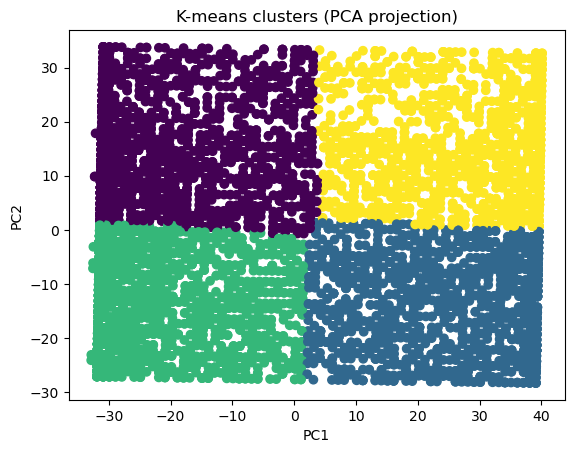

array([0.68137358, 0.3180274 ])

In [7]:
from sklearn.decomposition import PCA

X = seg_df_num.drop(columns=['cluster']).values
pca = PCA(n_components=2, random_state=943)
X2 = pca.fit_transform(X)

plt.figure()
plt.scatter(X2[:,0], X2[:,1], c=seg_df_num['cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means clusters (PCA projection)')
plt.show()

pca.explained_variance_ratio_

In [8]:
seg_df_num.groupby('cluster').mean()


,age_years,tenure_mo,contract_term,tech_support_std,has_dependents
cluster,,,,,
0,61.333977,14.082368,0.823681,0.180180,0.212355
1,33.440980,56.631774,0.192279,0.435041,0.418708
2,32.840796,12.093284,0.789801,0.193408,0.273632
3,62.043478,57.895297,0.255546,0.422360,0.306122


In [9]:
cluster_counts = seg_df_num['cluster'].value_counts()
cluster_pct = seg_df_num['cluster'].value_counts(normalize=True) * 100

cluster_summary = pd.DataFrame({
    'number': cluster_counts,
    'percentage': cluster_pct.round(1)
})

cluster_summary


,number,percentage
cluster,,
2,1608,28.5
0,1554,27.6
1,1347,23.9
3,1127,20.0
